Setup...

In [1]:
from __future__ import division

import numpy as np
import os
from glob import glob

from PIL import Image
from copy import deepcopy

from sklearn import linear_model, datasets, neighbors
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import svm

%matplotlib inline
from scipy.misc import imread, imresize
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

import pandas as pd

import scipy.stats as stats
from scipy.stats import norm
import sklearn

In [2]:
## define path to input datasets (tidy format)
path_to_recog = '/home/jefan/neurosketch/neurosketch_voxelmat_freesurfer_recog'
# path_to_recog = '/home/jgunn/neurosketch/recmatrices'
path_to_draw = '/home/jefan/neurosketch/neurosketch_voxelmat_freesurfer_drawing' 
# path_to_draw = '/home/jgunn/neurosketch/drawmatrices' 
roi_list = np.array(["V1", "V2", "LOC", "IT", "fusiform", "parahippo",  "PRC",  "ento", "hipp", 'mOFC', 'IFG', 'rostMFG', 'caudMFG', 'precentral', 'SMG', 'STG'])
# roi_formatted = np.array(["V1", "V2", "LOC", "IT", "fusiform", "para\nhippo",  "PRC",  "ento", "hipp", 'mOFC', 'IFG', 'rost\nMFG', 'caud\nMFG', 'pre\ncentral', 'SMG', 'STG'])

## get raw file list for recognition runs
RECOG_METAS = sorted([i for i in os.listdir(path_to_recog) if i.split('.')[-1]=='csv'])
RECOG_FEATS = sorted([i for i in os.listdir(path_to_recog) if i.split('.')[-1]=='npy'])
RECOG_SUBS = np.array([i.split('_')[0] for i in RECOG_FEATS])

recog_sub_list = np.unique(RECOG_SUBS)

def preprocess_recog(RECOG_METAS, RECOG_FEATS):
    M = [i for i in RECOG_METAS if len(i.split('.')[0].split('_'))==4]
    F = [i for i in RECOG_FEATS if len(i.split('.')[0].split('_'))==4]
    return M,F

RECOG_METAS, RECOG_FEATS = preprocess_recog(RECOG_METAS, RECOG_FEATS)


In [3]:
## get raw file list for drawing runs
DRAW_METAS = sorted([i for i in os.listdir(path_to_draw) if i.split('.')[-1]=='csv'])
DRAW_FEATS = sorted([i for i in os.listdir(path_to_draw) if i.split('.')[-1]=='npy'])
DRAW_SUBS = np.array([i.split('_')[0] for i in DRAW_FEATS])
draw_sub_list = np.unique(DRAW_SUBS)

In [4]:
## get subject ID's that have complete datasets from all phases of experiment
sub_list = np.intersect1d(recog_sub_list,draw_sub_list)
sub_list = [s for s in sub_list if s != '1207162']
print('Number of subs: {}'.format(len(sub_list)))

Number of subs: 30


In [5]:
## filter file list so only contains the sessions that have full datasets
def extract_good_sessions(DRAW_METAS,DRAW_FEATS,RECOG_METAS,RECOG_FEATS):
    _DRAW_METAS = [i for i in DRAW_METAS if i.split('_')[1] in sub_list]
    _DRAW_FEATS = [i for i in DRAW_FEATS if i.split('_')[0] in sub_list]
    _RECOG_METAS = [i for i in RECOG_METAS if i.split('_')[1] in sub_list]
    _RECOG_FEATS = [i for i in RECOG_FEATS if i.split('_')[0] in sub_list]
    return _DRAW_METAS, _DRAW_FEATS, _RECOG_METAS, _RECOG_FEATS

DRAW_METAS,DRAW_FEATS,RECOG_METAS,RECOG_FEATS =  \
extract_good_sessions(DRAW_METAS,DRAW_FEATS,RECOG_METAS,RECOG_FEATS)

RECOG_SUBS = np.array([i.split('_')[0]+'_neurosketch' for i in RECOG_FEATS])
RECOG_ROIS = np.array([i.split('_')[1] for i in RECOG_FEATS])

DRAW_SUBS = np.array([i.split('_')[0]+'_neurosketch' for i in DRAW_FEATS])
DRAW_ROIS = np.array([i.split('_')[1] for i in DRAW_FEATS])

### How well do we do at classifying the target when we train on recognition patterns only?

In [6]:
#### Helper data loader functions
def load_draw_meta(this_sub):
    this_file = 'metadata_{}_drawing.csv'.format(this_sub)
    x = pd.read_csv(os.path.join(path_to_draw,this_file))
    x = x.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)
    x['trial_num'] = np.repeat(np.arange(40),23)        
    return x
    
def load_draw_feats(this_sub,this_roi):
    this_file = '{}_{}_featurematrix.npy'.format(this_sub,this_roi)
    y = np.load(os.path.join(path_to_draw,this_file))
    y = y.transpose()
    return y

def load_draw_data(this_sub,this_roi):
    x = load_draw_meta(this_sub)
    y = load_draw_feats(this_sub,this_roi)
    assert y.shape[0] == x.shape[0]    
    return x,y

def load_recog_meta(this_sub,this_roi,this_phase):
    this_file = 'metadata_{}_{}_{}.csv'.format(this_sub,this_roi,this_phase)
    x = pd.read_csv(os.path.join(path_to_recog,this_file))
    x = x.drop(['Unnamed: 0'], axis=1)
    return x
    
def load_recog_feats(this_sub,this_roi,this_phase):
    this_file = '{}_{}_{}_featurematrix.npy'.format(this_sub,this_roi,this_phase)
    y = np.load(os.path.join(path_to_recog,this_file))
    y = y.transpose()
    return y    

def load_recog_data(this_sub,this_roi,this_phase):
    x = load_recog_meta(this_sub,this_roi,this_phase)
    y = load_recog_feats(this_sub,this_roi,this_phase)
    assert y.shape[0] == x.shape[0]    
    return x,y

# z-score normalization to de-mean & standardize variances within-voxel 
def normalize(X):
    X = X - X.mean(0)
    X = X / np.maximum(X.std(0), 1e-5)
    return X

## plotting helper
def get_prob_timecourse(iv,DM):
    trained_objs = np.unique(DM.label.values)
    t1 = trained_objs[0]
    t2 = trained_objs[1]
    target = np.vstack((DM[DM.label==t1].groupby(iv)['t1_prob'].mean().values,
                        DM[DM.label==t2].groupby(iv)['t2_prob'].mean().values)).mean(0) ## target timecourse; mean is taken over what?
    foil = np.vstack((DM[DM.label==t1].groupby(iv)['t2_prob'].mean().values,
                    DM[DM.label==t2].groupby(iv)['t1_prob'].mean().values)).mean(0) ## foil timecourse
    control = np.vstack((DM[DM.label==t1].groupby(iv)['ctrl_prob'].mean().values,
                        DM[DM.label==t2].groupby(iv)['ctrl_prob'].mean().values)).mean(0) ## control timecourse
    
    return target, foil, control
     
def flatten(x):
    return [item for sublist in x for item in sublist]    

In [7]:
# inds =(ALLDM['roi']=='V1') & (ALLDM['subj']=='0110171') 
# get_prob_timecourse('time_point',ALLDM[inds])

In [8]:
## general plotting params
sns.set_context('poster')
colors = sns.color_palette("cubehelix", 5)


In [9]:
## example subject, roi, and phase (localizer is default)
this_sub = sub_list[0]
this_roi = roi_list[2] ## order is: ['V1','V2','LOC','IT','fusiform','parahippo', 'PRC', 'ento','hipp','mOFC']
this_phase = '12' ## options are '12', '34', '56'

In [ ]:
ALLDM = []

## loop through all subjects and rois
Acc = []
for this_roi in roi_list:
    print (this_roi)
    acc = []
    for this_sub in sub_list:
        print(this_sub)
        ## load subject data in
        RM12, RF12 = load_recog_data(this_sub,this_roi,'12')
        RM34, RF34 = load_recog_data(this_sub,this_roi,'34')        
        RM = pd.concat([RM12,RM34])
        RF = np.vstack((RF12,RF34))        
        DM, DF = load_draw_data(this_sub,this_roi)
        assert RF.shape[1]==DF.shape[1] ## that number of voxels is identical
        
        # identify control objects; 
        # we wil train one classifier with 
        trained_objs = np.unique(DM.label.values)
        control_objs = [i for i in ['bed','bench','chair','table'] if i not in trained_objs]
        probs = []
        
        for ctrl in control_objs:
            
            inds = RM.label != ctrl
            _RM = RM[inds]

            ## normalize voxels within task
            normalize_on = 1
            if normalize_on:
                _RF = normalize(RF[inds,:])
                _DF = normalize(DF)
            else:
                _RF = RF[inds,:]
                _DF = DF

            # single train/test split
            X_train = _RF # recognition run feature set
            y_train = _RM.label.values # list of labels for the training set

            ## subset timepoints?
            inds = DM.time_point>0 # all timepoints are > 0, so no subsetting happens
            _DF = _DF[inds,:]
            DM = DM[inds]

            X_test = _DF
            y_test = DM.label.values
            # clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
            clf = linear_model.LogisticRegression(penalty='l2',C=1).fit(X_train, y_train)    

            ## add prediction probabilities to metadata matrix
            ## must sort so that trained are first, and control is last
            cats = list(clf.classes_)
            ctrl_index = cats.index([c for c in control_objs if c != ctrl][0])
            t1_index = cats.index(trained_objs[0])
            t2_index = cats.index(trained_objs[1])
            ordering = np.argsort([t1_index, t2_index, ctrl_index])
            probs.append(clf.predict_proba(X_test)[:,ordering])

        DM['t1_prob'] = (probs[0][:,0] + probs[1][:,0])/2.0
        DM['t2_prob'] = (probs[0][:,1] + probs[1][:,1])/2.0
        DM['ctrl_prob'] = (probs[0][:,2] + probs[1][:,2])/2.0
        
        DM['subj'] = np.repeat(this_sub,DM.shape[0])
        DM['roi'] = np.repeat(this_roi,DM.shape[0])
        
        if len(ALLDM)==0:
            ALLDM = DM
        else:
            ALLDM = pd.concat([ALLDM,DM],ignore_index=True)

        ## plot probability timecourse
        fig = plt.figure(figsize=(5,5))
        iv = 'run_num'
        t,f,c = get_prob_timecourse(iv,DM)
        plt.plot(t,color=colors[0],label='target')
        plt.plot(f,color=colors[1],label='foil')
        plt.plot(c,color=colors[2],label='control')
        plt.legend(bbox_to_anchor=(1.45, 1.01))
        plt.ylim(0,1)
        plt.xlabel(iv)
        plt.ylabel('probability')
        if not os.path.exists('./plots/subj'):
            os.makedirs('./plots/subj')
        plt.tight_layout()
        plt.savefig('./plots/subj/{}_{}_prob_{}.pdf'.format(iv.split('_')[0],this_roi,this_sub))
        plt.close(fig)
        acc.append(clf.score(X_test, y_test))
    
    Acc.append(acc)

V1
0110171
0110172
0111171
0112171
0112172
0112173
0113171
0115174
0117171
0118171
0118172
0119171
0119172
0119173
0119174
0120171
0120172
0120173
0123171
0123173
0124171
0125171
0125172
1121161
1130161
1202161
1203161
1206161
1206162
1206163
V2
0110171
0110172
0111171
0112171
0112172
0112173
0113171
0115174


In [10]:
        #trained_objs = np.unique(DM.label.values)
        #control_objs = [i for i in ['bed','bench','chair','table'] if i not in trained_objs]
        #inds = DM.label != 'chair' # all timepoints are > 0, so no subsetting happens
        
#np.shape(probs)
#(probs[0][:,0] + probs[1][:,0])/2.0

In [28]:
ALLDM = ALLDM.drop(['Unnamed: 0.1.1'],axis=1)

ValueError: labels ['Unnamed: 0.1.1'] not contained in axis

In [10]:
Acc = np.array(Acc) # 10 ROIs, 31 subjects. A score representing classification performance for that subject/roi pair
x = pd.DataFrame(Acc.transpose())
x.columns = roi_formatted

x # x is acc formatted into a ROI x subject dataframe

,V1,V2,LOC,IT,fusiform,para hippo,PRC,ento,hipp,mOFC,IFG,rost MFG,caud MFG,pre central,SMG,STG
0,0.333696,0.369565,0.368478,0.343478,0.304348,0.342391,0.357609,0.348913,0.335870,0.343478,0.315217,0.270652,0.357609,0.305435,0.321739,0.343478
1,0.305435,0.316304,0.364130,0.339130,0.358696,0.334783,0.330435,0.346739,0.331522,0.340217,0.331522,0.348913,0.342391,0.307609,0.344565,0.339130
2,0.332609,0.329348,0.297826,0.382609,0.380435,0.320652,0.354348,0.333696,0.307609,0.351087,0.380435,0.319565,0.325000,0.343478,0.360870,0.332609
3,0.408696,0.391304,0.272826,0.338043,0.354348,0.343478,0.326087,0.328261,0.313043,0.314130,0.348913,0.367391,0.340217,0.336957,0.330435,0.332609
4,0.319565,0.382609,0.338043,0.336957,0.326087,0.342391,0.348913,0.354348,0.311957,0.336957,0.320652,0.318478,0.357609,0.341304,0.339130,0.296739
5,0.476087,0.484783,0.444565,0.338043,0.336957,0.339130,0.319565,0.331522,0.326087,0.314130,0.296739,0.338043,0.343478,0.383696,0.378261,0.303261
6,0.391304,0.378261,0.406522,0.342391,0.331522,0.302174,0.278261,0.343478,0.336957,0.360870,0.295652,0.332609,0.342391,0.358696,0.369565,0.342391
7,0.526087,0.454348,0.426087,0.338043,0.341304,0.321739,0.332609,0.326087,0.372826,0.338043,0.351087,0.314130,0.409783,0.365217,0.282609,0.382609
8,0.394565,0.398913,0.369565,0.370652,0.339130,0.346739,0.342391,0.341304,0.356522,0.336957,0.335870,0.346739,0.317391,0.319565,0.389130,0.330435
9,0.397826,0.356522,0.319565,0.311957,0.303261,0.332609,0.334783,0.361957,0.313043,0.346739,0.354348,0.350000,0.335870,0.348913,0.344565,0.328261


(0, 0.45)

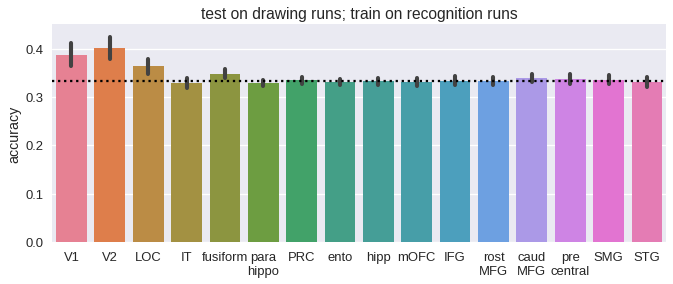

In [11]:
sns.set_context('talk')
plt.figure(figsize=(11,4))
sns.barplot(data=x,palette='husl',ci=95) # very amazing thing sns must be!
plt.axhline(1/3,linestyle=':',color='k')
plt.ylabel('accuracy')
plt.title('test on drawing runs; train on recognition runs')
plt.ylim(0,0.45)

In [12]:
ALLDM.to_csv('./logistic_timeseries_neural_vgg.csv') ## train recog, test drawing run

In [ ]:
ALLDM.head()

,subj,label,run_num,TR_num,time_point,trial_num,t1_prob,t2_prob,ctrl_prob,roi
0,0110171,bed,1,10,1,0,0.849860,0.011288,0.138852,V1
1,0110171,bed,1,11,2,0,0.969912,0.008953,0.021136,V1
2,0110171,bed,1,12,3,0,0.371163,0.179743,0.449093,V1
3,0110171,bed,1,13,4,0,0.248547,0.407146,0.344307,V1
4,0110171,bed,1,14,5,0,0.540043,0.003985,0.455972,V1


Now how does this code work?

`lookup` is weird.

Scans through `['run_num','trial_num','time_point']`, then ROIs, then subjects too.

Now what is T F C? Target Foil Control. uses the helper function on a subset of ALLDMS that focuses on this roi and this subject. How does that function work?
seems to first take the unique set of labels..? How is he telling between target and off-target objs? Seems there's an ordering, and unique preserves it? Drawing trials will always only be the trained ones. Duh. Control is never the accurate thing, but it always gets assigned a score. This'll make the other coding problem easier.

So it isolates by roi, subject and object, groups iteratively by ['run_num','trial_num','time_point'] and takes the mean across those groupings for each object category. So I get 4 means for 4 runs, and 3 sets of means, one for each condition. Need more focus on how foil is calculated, though. It's just t2, that's all.

So let's start over knowing what I know. Scanning through the units I want my timecourse taken over (runs, trials, timepoints), then over ROIs, then over subjects. On the subject level, I'm getting the probability time course over the current iv for trained, foil, and control. For each sub, store said timecourse in T, F, or C. DTF DTC and DFC are the differences from D to F, etc. If render cond is positive, the plot will be trained, foil, control. Otherwise, it's DTF and so forth. 

Then generate graph for this. DOn't know if I need to know the details. I'm looking to set up the final graphs. Instead of drawing from mean over this probability time course, draw the max or the max difference. 

Seems I also need to do this for DTF over repetitions. Take correlations of these for each subject (rather than max or mean). ANd then plot those correlations. Where?

In [ ]:
sns.set_context('paper')
this_roi = 'V1'
subs = np.unique(ALLDM.subj.values) # list of subjects pulled from ALLDM.
lookup = dict(zip(['trial_num','run_num','time_point'],['repetition','run','TR']))
ivs = ['run_num','trial_num','time_point']
this_iv = 'time_point'

## do you want to render the CONDITION-wise plots -- trained vs. foil vs control
## or the DIFFERENCE plots -- trained - foil vs foil - control?
render_cond = 1

for this_iv in ivs:
    for this_roi in roi_list:

        T = []
        F = []
        C = []
        Sub = []
        for sub in subs:
            inds =(ALLDM['roi']==this_roi) & (ALLDM['subj']==sub) 
            t,f,c = get_prob_timecourse(this_iv,ALLDM[inds])
            if len(T)==0:
                T = t
                F = f
                C = c
                DTF = t-f                
                DTC = t-c
                DFC = f-c
            else:
                T = np.hstack((T,t))
                F = np.hstack((F,f))        
                C = np.hstack((C,c)) 
                DTF = np.hstack((DTF,t-f))                
                DTC = np.hstack((DTC,t-c))
                DFC = np.hstack((DFC,f-c))
            Sub.append([sub]*len(t))   
        
        if render_cond==1:
            ## make longform version of dataframe to use in tsplot (by condition)            
            Trial = np.tile(np.arange(len(t)),len(subs)*3)
            Condition = np.repeat(['trained','foil','control'],len(T))
            Sub = np.tile(np.array(flatten(Sub)),3)
            Prob = np.hstack((T,F,C))
            assert len(Trial)==len(Condition)
            assert len(Sub)==len(Prob)
            assert len(Condition)==len(Sub)
            x = pd.DataFrame([Prob,Trial,Condition,Sub])
            x = x.transpose()
            x.columns = ['probability',lookup[this_iv],'condition','sub']
            toop = 'condition3way'
        else:
            ## make longform version of dataframe to use in tsplot (difference btw conditions)                    
            Trial = np.tile(np.arange(len(t)),len(subs)*3)
            Condition = np.repeat(['trained-foil','trained-control','foil-control'],len(T))
            Sub = np.tile(np.array(flatten(Sub)),3)
            Prob = np.hstack((DTF,DTC,DFC))        
            assert len(Trial)==len(Condition)
            assert len(Sub)==len(Prob)
            assert len(Condition)==len(Sub)
            x = pd.DataFrame([Prob,Trial,Condition,Sub])
            x = x.transpose()
            x.columns = ['probability',lookup[this_iv],'condition','sub']        
            toop = 'difference3way'
        fig = plt.figure(figsize=(8,4))
        ## plot it
        sns.tsplot(data=x,
                  time=lookup[this_iv],
                  unit='sub',
                  condition='condition',
                  value='probability',
                  ci=95)
        if render_cond==1:
            plt.ylim(0,2/3)
            plt.axhline(1/3,linestyle=':',color='k')  
            plt.legend(bbox_to_anchor=(0.8, 1.01))  
            plt.title('Classifier evidence by condition in {}'.format(this_roi))
            
        else:
            plt.ylim(-0.3,0.3)
            plt.axhline(0,linestyle=':',color='k')  
            plt.legend(bbox_to_anchor=(0.7, 1.01))                        
            plt.title('Difference in classifier evidence by condition in {}'.format(this_roi))        
        plt.xticks(np.arange(np.max(x[lookup[this_iv]].values)+1))
        if not os.path.exists('./plots/roi/{}/{}'.format(lookup[this_iv],toop)):
            os.makedirs('./plots/roi/{}/{}'.format(lookup[this_iv],toop))
        plt.tight_layout()        
        plt.savefig('./plots/roi/{}/{}/prob_timecourse_{}_by_{}.pdf'.\
                    format(lookup[this_iv],toop,this_roi,lookup[this_iv]))
        plt.close(fig)

What does this mean...Seems to be calculate of the bottom part of the graph. Look for the mean...There it is! Just swap that for max, and you have it. Though, that's the max difference.

In [ ]:
ALLDM

In [ ]:
## get subject-level index of contrast between objects during drawing
sub_tf = []
sub_tc = []
sub_fc = []
roi = []

subs = np.unique(ALLDM.subj.values)
ivs = ['time_point'] ## other optoins 'run_num','trial_num',

## do you want to render the CONDITION-wise plots -- trained vs. foil vs control
## or the DIFFERENCE plots -- trained - foil vs foil - control?
render_cond = 0

for this_iv in ivs:
    for this_roi in roi_list:

        T = []
        F = []
        C = []
        Sub = []
        for sub in subs:
            inds =(ALLDM['roi']==this_roi) & (ALLDM['subj']==sub) 
            t,f,c = get_prob_timecourse(this_iv,ALLDM[inds])
            if len(T)==0:
                T = t
                F = f
                C = c
                DTF = t-f                
                DTC = t-c
                DFC = f-c
            else:
                T = np.hstack((T,t))
                F = np.hstack((F,f))        
                C = np.hstack((C,c)) 
                DTF = np.hstack((DTF,t-f))                
                DTC = np.hstack((DTC,t-c))
                DFC = np.hstack((DFC,f-c))
            Sub.append([sub]*len(t))   
          
        ## make longform version of dataframe to use in tsplot (difference btw conditions)                    
        Trial = np.tile(np.arange(len(t)),len(subs)*3)
        Condition = np.repeat(['trained-foil','trained-control','foil-control'],len(T))
        Sub = np.tile(np.array(flatten(Sub)),3)
        Prob = np.hstack((DTF,DTC,DFC))        
        assert len(Trial)==len(Condition)
        assert len(Sub)==len(Prob)
        assert len(Condition)==len(Sub)
        x = pd.DataFrame([Prob,Trial,Condition,Sub])
        x = x.transpose()
        x.columns = ['probability',lookup[this_iv],'condition','sub']
        
        for this_sub in subs:
            sub_tf.append(x[(x['condition']=='trained-foil') & (x['sub']==this_sub)]['probability'].mean())
            sub_tc.append(x[(x['condition']=='trained-control') & (x['sub']==this_sub)]['probability'].mean())  
            sub_fc.append(x[(x['condition']=='foil-control') & (x['sub']==this_sub)]['probability'].mean()) 
            roi.append(this_roi)
            
## make dataframe with subject-level difference scores
d = pd.DataFrame([sub_tf,sub_tc,sub_fc,roi])
d = d.transpose()
d.columns = ['trained-foil','trained-control','foil-control','roi']

In [19]:
d[d['roi']=='V1']

,trained-foil,trained-control,foil-control,roi
0,0.0635827,0.0198272,-0.0437555,V1
1,-0.0334843,-0.0310782,0.00240607,V1
2,0.0388928,0.0251947,-0.0136981,V1
3,-0.0634979,-0.0447422,0.0187557,V1
4,0.00228408,0.0149281,0.012644,V1
5,0,0.0241669,0.0241669,V1
6,-0.052651,-0.0327895,0.0198615,V1
7,-0.128041,-0.0469741,0.0810673,V1
8,-0.0417419,-0.0192479,0.022494,V1
9,0,0.012598,0.012598,V1


Just tests if any of these differences are reliably different from zero. Some are, even taking into account multiple measurements. 

In [27]:
for this_roi in roi_list:
    data = d[d['roi']==this_roi]['trained-foil']
    t,p = stats.ttest_1samp(data,0)
    print ('ROI = {} | t = {}, p = {}'.format(this_roi,t,p))

ROI = V1 | t = 2.768736123485365, p = 0.009554778830532455
ROI = V2 | t = 2.770583015369253, p = 0.0095119210686561
ROI = LOC | t = 4.596186237182268, p = 7.268034217384911e-05
ROI = IT | t = 0.32746038433578734, p = 0.7455939050323976
ROI = fusiform | t = 2.1010699856853625, p = 0.04414153968778241
ROI = parahippo | t = 0.5293455190029417, p = 0.6004613045029474
ROI = PRC | t = 0.016453483562522103, p = 0.986981551664948
ROI = ento | t = -0.6840172702888475, p = 0.49921431079537637
ROI = hipp | t = -1.0407359788537531, p = 0.3063133092292496
ROI = mOFC | t = 0.5196500057946879, p = 0.6071208489160427


In [28]:
for this_roi in roi_list:
    data = d[d['roi']==this_roi]['trained-control']
    t,p = stats.ttest_1samp(data,0)
    print ('ROI = {} | t = {}, p = {}'.format(this_roi,t,p))

ROI = V1 | t = 1.6636248275724903, p = 0.10660079640244327
ROI = V2 | t = 2.2139350332488115, p = 0.03457771253468806
ROI = LOC | t = 2.415038847515531, p = 0.02203647713504597
ROI = IT | t = -0.3861479810294371, p = 0.7021121715021897
ROI = fusiform | t = 1.6227296794866946, p = 0.11511072025005005
ROI = parahippo | t = -0.27083607057368286, p = 0.7883718940652598
ROI = PRC | t = 1.2985961595839934, p = 0.20397641602298494
ROI = ento | t = 0.6538942794524435, p = 0.5181612790511406
ROI = hipp | t = -0.4834968962225369, p = 0.6322533131124466
ROI = mOFC | t = 0.4752748443740968, p = 0.6380333575379928


In [29]:
for this_roi in roi_list:
    data = d[d['roi']==this_roi]['foil-control']
    t,p = stats.ttest_1samp(data,0)
    print ('ROI = {} | t = {}, p = {}'.format(this_roi,t,p))

ROI = V1 | t = -2.3466838298413037, p = 0.0257378940389738
ROI = V2 | t = -2.5411352786501786, p = 0.016457522733690673
ROI = LOC | t = -3.1123034695161897, p = 0.004055278623925445
ROI = IT | t = -0.8491410233102968, p = 0.4025281934473953
ROI = fusiform | t = -1.4784845160787863, p = 0.14970188244735996
ROI = parahippo | t = -0.9710093202551024, p = 0.33930791332804766
ROI = PRC | t = 0.9153607662983471, p = 0.36730173339353445
ROI = ento | t = 1.3457073383157303, p = 0.1884798586934702
ROI = hipp | t = 0.8915989428781647, p = 0.37970360289586
ROI = mOFC | t = 0.1614653384488601, p = 0.8728094242188358


A simple graph. X is foil-control, y is prepostdiff scores. Plot points, correlation, etc. All I'm changing is x-axis, and I'm doing it above. Cool. 

In [30]:
prepost = pd.read_csv('neural_changes_by_surfroi_and_subject.csv')

In [31]:
## make dataframe to relate drawing contrast to recognition differentiation
roi_list = ['V1', 'V2', 'LOC', 'IT', 'fusiform', 'parahippo', 'PRC', 'ento','hipp', 'mOFC']
this_roi = 'hipp'

for this_roi in roi_list:
    print(this_roi)
    draw = d[d['roi']==this_roi]['trained-control'].values - d[d['roi']==this_roi]['foil-control'].values
    recog = prepost['tradiff_{}'.format(this_roi)].values-prepost['condiff_{}'.format(this_roi)].values

    z = pd.DataFrame([draw,recog])
    z = z.transpose()
    z.columns=['draw','recog']

    ## plot 
    fig = plt.figure(figsize=(6,6))
    sns.set_context('poster')
    sns.regplot(x="draw",
                y ="recog",
                data=z)
    r,p = stats.pearsonr(draw,recog)
    plt.title('ROI: {}  r={}  p={}'.format(this_roi,np.round(r,3),np.round(p,3)))
    if not os.path.exists('./plots/roi/drawrecog'):
        os.makedirs('./plots/roi/drawrecog')
    plt.tight_layout()
    plt.savefig('./plots/roi/drawrecog/draw_recog_scatter_{}.pdf'.format(this_roi))
    plt.close(fig)    
    

V1
V2
LOC
IT
fusiform
parahippo
PRC
ento
hipp
mOFC


### relate neural to vgg drawing time series

In [23]:
vgg_ts = pd.read_csv('./logistic_timeseries_drawing_vgg.csv')
neural_ts = pd.read_csv('./logistic_timeseries_drawing_neural.csv')

FileNotFoundError: File b'./logistic_timeseries_drawing_vgg.csv' does not exist

In [793]:
vgg_ts = vgg_ts.drop(['Unnamed: 0','Unnamed: 0.1'],axis=1)
vgg_ts.wID = [i.split('_')[0] for i in vgg_ts.wID.values]

In [794]:
vgg_ts.head()

,index,wID,viewpoint,trial,trialDuration,target,competitor,numSketch,bed,bench,chair,table,curr_winner,tc_pair,trialID,run,target_val,competitor_val,control_val
0,0,0119174,20,320,39.00144,bench,chair,0,0.026822,0.055895,0.916243,0.001040,chair,bench/chair,0119174_neurosketch_320,1.0,0.055895,0.916243,0.013931
1,0,0119174,20,320,39.00144,bench,chair,1,0.934225,0.026225,0.039085,0.000465,bed,bench/chair,0119174_neurosketch_320,1.0,0.026225,0.039085,0.467345
2,0,0119174,20,320,39.00144,bench,chair,2,0.006035,0.970770,0.002714,0.020481,bench,bench/chair,0119174_neurosketch_320,1.0,0.970770,0.002714,0.013258
3,0,0119174,20,320,39.00144,bench,chair,3,0.009842,0.978927,0.003784,0.007447,bench,bench/chair,0119174_neurosketch_320,1.0,0.978927,0.003784,0.008644
4,0,0119174,20,320,39.00144,bench,chair,4,0.019298,0.967674,0.001463,0.011564,bench,bench/chair,0119174_neurosketch_320,1.0,0.967674,0.001463,0.015431


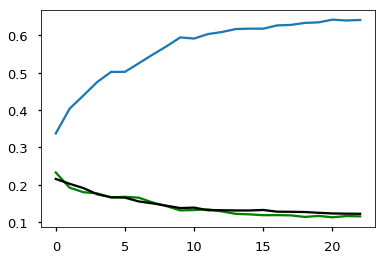

In [800]:
plt.plot(vgg_ts.groupby('numSketch')['target_val'].mean())
plt.plot(vgg_ts.groupby('numSketch')['competitor_val'].mean(),color='green')
plt.plot(vgg_ts.groupby('numSketch')['control_val'].mean(),color='black')

In [ ]:
## plotting helper
def get_vgg_timecourse(iv,DM):
    trained_objs = np.unique(DM.target.values)
    control_objs = [i for i in ['bed','bench','chair','table'] if i not in trained_objs]
    t1 = trained_objs[0]
    t2 = trained_objs[1]
    c1 = control_objs[0]
    c2 = control_objs[1]
    target = np.vstack((DM[DM.label==t1].groupby(iv)['{}_prob'.format(t1)].mean().values,
                   DM[DM.label==t2].groupby(iv)['{}_prob'.format(t2)].mean().values)).mean(0) ## target timecourse
    foil = np.vstack((DM[DM.label==t1].groupby(iv)['{}_prob'.format(t2)].mean().values,
                   DM[DM.label==t2].groupby(iv)['{}_prob'.format(t1)].mean().values)).mean(0) ## foil timecourse
    control = np.vstack((DM[DM.label==t1].groupby(iv)['{}_prob'.format(c1)].mean().values,
                        DM[DM.label==t1].groupby(iv)['{}_prob'.format(c2)].mean().values,
                        DM[DM.label==t2].groupby(iv)['{}_prob'.format(c1)].mean().values,
                        DM[DM.label==t2].groupby(iv)['{}_prob'.format(c2)].mean().values)).mean(0) ## control timecourse
    
    return target, foil, control

In [787]:
T = []
F = []
C = []
Sub = []
for sub in subs:
    inds =(vgg_ts['wID']==sub) 
    t,f,c = get_prob_timecourse(this_iv,vgg_ts[inds])
    
    
    if len(T)==0:
        T = t
        F = f
        C = c
        DTF = t-f                
        DTC = t-c
        DFC = f-c
    else:
        T = np.hstack((T,t))
        F = np.hstack((F,f))        
        C = np.hstack((C,c)) 
        DTF = np.hstack((DTF,t-f))                
        DTC = np.hstack((DTC,t-c))
        DFC = np.hstack((DFC,f-c))
    Sub.append([sub]*len(t))   

## make longform version of dataframe to use in tsplot (difference btw conditions)                    
Trial = np.tile(np.arange(len(t)),len(subs)*3)
Condition = np.repeat(['trained-foil','trained-control','foil-control'],len(T))
Sub = np.tile(np.array(flatten(Sub)),3)
Prob = np.hstack((DTF,DTC,DFC))        
assert len(Trial)==len(Condition)
assert len(Sub)==len(Prob)
assert len(Condition)==len(Sub)
x = pd.DataFrame([Prob,Trial,Condition,Sub])
x = x.transpose()
x.columns = ['probability',lookup[this_iv],'condition','sub']

array(['0110171', '0110172', '0111171', '0112171', '0112172', '0112173',
       '0113171', '0115174', '0117171', '0118171', '0118172', '0119171',
       '0119172', '0119173', '0119174', '0120171', '0120172', '0120173',
       '0123171', '0123173', '0124171', '0125171', '0125172', '1121161',
       '1130161', '1202161', '1203161', '1206161', '1206162', '1206163',
       '1207162'], dtype=object)

In [11]:
print(sorted(['1121161_neurosketch', '1130161_neurosketch', '1202161_neurosketch', '1203161_neurosketch', '1206161_neurosketch', '1206162_neurosketch', '1206163_neurosketch', '1207162_neurosketch', '0110171_neurosketch', 
                '0110172_neurosketch', '0111171_neurosketch', '0112171_neurosketch', '0112172_neurosketch', '0112173_neurosketch', '0113171_neurosketch', '0115174_neurosketch', '0117171_neurosketch', '0118171_neurosketch', 
                '0118172_neurosketch', '0119171_neurosketch', '0119172_neurosketch', '0119173_neurosketch', '0119174_neurosketch', '0120171_neurosketch', '0120172_neurosketch', '0120173_neurosketch', '0123171_neurosketch', 
                '0123173_neurosketch', '0124171_neurosketch', '0125171_neurosketch', '0125172_neurosketch']))

['0110171_neurosketch', '0110172_neurosketch', '0111171_neurosketch', '0112171_neurosketch', '0112172_neurosketch', '0112173_neurosketch', '0113171_neurosketch', '0115174_neurosketch', '0117171_neurosketch', '0118171_neurosketch', '0118172_neurosketch', '0119171_neurosketch', '0119172_neurosketch', '0119173_neurosketch', '0119174_neurosketch', '0120171_neurosketch', '0120172_neurosketch', '0120173_neurosketch', '0123171_neurosketch', '0123173_neurosketch', '0124171_neurosketch', '0125171_neurosketch', '0125172_neurosketch', '1121161_neurosketch', '1130161_neurosketch', '1202161_neurosketch', '1203161_neurosketch', '1206161_neurosketch', '1206162_neurosketch', '1206163_neurosketch', '1207162_neurosketch']
